# Homophily

In this notebook, we present the implementation of an Homophily Dynamics. Homophily refers to the tendency of individuals to associate with others with the same characteristics. For more information related to the Homophily Dynamics you can refer to this link in [wiki] (https://en.wikipedia.org/wiki/Homophily)

#  ** Homophily Dinamics on a Network **

** Node Structure **

Let us consider a Network $G(\mathcal{N})$, with a given topology, where $\mathcal{N}$ stand for the set nodes that compose the Network. Each node $n_i \in \mathcal{N}$ has the following attributes:
*   State.- wich is a vector of parameters $C_i = (\sigma_{i1},\sigma_{i2}, \dots , \sigma_{iF})$, where $\sigma_{if} \in {0,\dots,q-1}$. Note that $F$ is the length of the vector $C_i$ and $q$ is the number of possibilities for each parameter.
*   Neighbors.- vector with indices of the othe nodes denoted by $neigh_i$, wich encode the topology of the Network $G$
Note that the number of possible states is given by $q^F$

** Example: **

** Let fix $F = 3$ and $q = 2$, then we have $8$ possible states. **

state 1 = (0 0 0);

state 2 = (0 0 1);

state 3 = (0 1 0);

state 4 = (1 0 0);

state 5 = (1 1 0);

state 6 = (1 0 1);

state 7 = (0 1 1);

state 8 = (1 1 1).

Here we have that $C_i= (\sigma_{i1},\dots,\sigma_{i8})$ and each $\sigma_{if} \in \{0,1\}$

** Dynamics ** 

Now, let us describe the homophily dynamic on the network $G$. 

For each $n_i \in G$, we have the following steps:

* First, for each $n_j \in neigh_i$ we compute the probabilty of interaction given by $$ p_{ij} = \frac{\sum_{f=1}^{F} \delta_{\sigma_{if}, \sigma_{jf}} }{F} $$

This count the similarities of the states of the node with it neighbors.

![int.png](Images/interaction.png)

* Then, with probabilty $p_{ij}$ a non similar random element of $C_j$ is copied to $C_i$, $$ \sigma_{ik} = \sigma_{jk} $$

** Example **

![ex.png](Images/example.png)

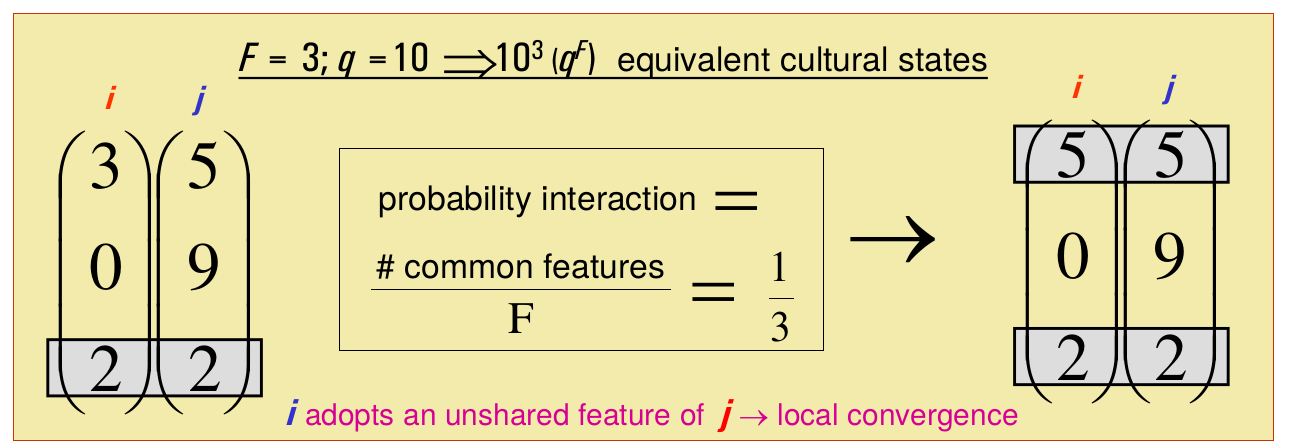

# ** Main Code **

## Libraries

First, we import some important libraries. Here, we export a library known as Networkx, Numpy (numerics) and random to simplify the procedures. 
See the following link for references:
- [Networkx Documentation](https://networkx.github.io/documentation/stable/tutorial.html).
- [Numpy] (https://numpy.org/).
- [Random] (https://docs.python.org/3/library/random.html).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

We defined the class Homophily with the attributes needed to the dynamic.

In [ ]:
class Homophily():

    def __init__(self, graph, tot_par, tot_opt, n_ch, T):
        """ Define an Homophily Dinamics:
            graph is nx.Graph() with a given topology.
            tot_par is total number of parameters (F).
            tot_op is the total number of options per parameter (q).
            n_ch is the total number of parameter to change when two nodes interact.
            T is the total number of steps in the dynamics.
        """
        self.graph = graph
        self.tot_par = tot_par
        self.tot_opt = tot_opt
        self.n_ch = n_ch
        self.T = T

The $Homophily$ class fucntions are separated in two sections. One set of them focus on the dynamics and the other ones to the graphical part of the simulations.

# Dynamic Functions

In [ ]:
# Create random attributes per each node in the network
    def add_attributes(self):
        graph = self.graph
        # Get the number of options
        opt = range(self.tot_opt)
        # Get the total number of nodes
        N = graph.number_of_nodes()
        # Create a dictionarie
        dic = {}
        for i in range(N):
            # Create a vector of parameters C_i 
            vec_par = []
            for par in range(self.tot_par):
                # Add a parameter given the number of options
                vec_par.append(random.choice(opt))
            # Add the vector of parameters to the dictionarie
            dic.update({ i: { 'param' : vec_par}})
        # Add the dictionarie to the network graph
        nx.set_node_attributes(graph, dic)

   
    # Function that run the homophily dynamic on a node
    def node_dyn(self, current_id):
        graph = self.graph
        # Get the nodes of the graph
        nodes = graph.nodes()

        # Get the current node 
        n1 = current_id

        # Get the list of neighbors neigh_i
        neigh_n1 = list(nx.neighbors(graph, n1))

        # Choose a random neighbor of n1
        n2=random.choice(neigh_n1)
        
        # Get the parameters of the two nodes involved in the dynamic
        param_n1 = nodes[n1]['param']
        param_n2 = nodes[n2]['param']

        # Get the Similarity vector. 1 equal, 0 diff   
        vec_sim= self.similarities(param_n1,param_n2)      

        # Compute the probability of interaction
        P = np.sum(vec_sim)/self.tot_par   
        
        # With probability P
        if(random.random()<P):
            
            # Choose a vector of random indices of length n_ch
            # with the choosen parameters to copy from n2 to n1
            # Cj to C_i
            atrs_ch=select_atr(vec_sim, self.n_ch, self.tot_par)  
            
            # Copy of the parameters of n2 to n1    
            for atr in atrs_ch:
                param_n1[atr] = param_n2[atr]
                
            # Update the parameters of the node n1
            n1_update = {n1: {'param': param_n1}}
            # update the attributes of the nodes in the graph
            nx.set_node_attributes(graph, n1_update)

    # Function that take two vectors and return a vector of  0 and 1
    # 1 when the elements are equal and 0 when they are different
    def similarities(self, param_n1, param_n2):
        # Initiate the similarities vector
        vec_s=[]
        # Compute the similarities
        for i in range(self.tot_par):
            if param_n1[i] == param_n2[i]:
                vec_s.append(1)
            else:
                vec_s.append(0)
        return vec_s


    # Function that run the homophily dynamics over all the nodes of the network.
    def dynamic_step(self):
        # Get the total number of nodes
        N = self.graph.number_of_nodes()
        for i in range(N):
            # Run the node dynamic per each node
            self.node_dyn(i)
        # Set the colors in dependence of the state of the nodes
        self.set_colors()

# Drawing Functions

In [ ]:
#-----------------------------DRAWING FUNCTIONS-------------------------------------#

    # Function to run a graphical simulation
    def graph_simulation(self):
        # Create an enviroment that can change
        plt.ion()
        fig=plt.figure()
        # Add the attributes to the nodes of the network
        self.add_attributes()
        # Run the simulation for T steps
        for t in range(self.T):
            # Run one step of the dynamics
            self.dynamic_step()
            # Draw the network in the given state
            self.draw_network()
            # Show the drawed network
            plt.show()
            # Delay for the next step
            plt.pause(0.001)

    # Function to run a graphical simulation that interact with click events
    def graph_click_simulation(self):
        # Add the attributes to the nodes of the network
        self.add_attributes()
        # Create a figure
        fig =plt.figure()
        # Call of the main function of drawing with a click of the mouse
        fig.canvas.mpl_connect('button_press_event', self.event_simulation )
        plt.show()
        plt.draw()

    # Function that give a numerical value in n_base of the parameters of a given
    # Node
    # Example:  
    # In binary base we have that
    #   (0 0 0) => 0
    #   (0 0 1) => 1
    #   (0 1 0) => 2
    #   (0 1 1) => 3
    # In ternary base
    #   (0 0 0) => 0
    #   (0 0 1) => 1
    #   (0 0 2) => 2
    #   (0 1 0) => 3
    #   (0 1 1) => 4
    #   (0 2 1) => 5
    def n_base_transf(self, current_id):
        # Get the nodes of the graph
        nodes = self.graph.nodes()
        # Get the number of options (P), which is the base
        base = self.tot_opt
        # Get the length of the vectors (F)
        length = self.tot_par
        # Get the parameters of the node
        vec_param = nodes[current_id]['param']
        # Initiate the sumation
        sumation = 0
        # Transform the vect in the F_base to a numerical value
        for i in range(length):
            sumation += base**i * vec_param[i]
        return sumation
    

    # Function to set the color of the nodes in dependence of the parameters
    def set_colors(self):
        # Get the number of options (q)
        base = self.tot_opt
        # Get the lengthof the vector of parameters (F)
        length = self.tot_par
        # Get the number of nodes
        N = self.graph.number_of_nodes()
        # Get the nodes of the graph
        nodes = self.graph.nodes()
        # Define an step for the colors 
        step = 1/(base**length)
        # Define a lambda function to define colors
        val_map = lambda i:  step*i 
        # The colors are given a numerical value between (0,1)
        # The color will the depend of the number of the state in the F_base
        for nd in range(N):
            # Assign the numerical value between (0,1)
            col_nd = val_map(self.n_base_transf(nd))
            # Add the attribute color to the nodes
            nodes[nd]['color'] = col_nd
    
    #Function to plot the structure of the network
    def draw_network(self):
        plt.clf()
        graph = self.graph
        # Get the nodes of the network
        nodes = graph.nodes()
        # Convert the nodes into a list of nodes
        lst_nodes = list(graph.nodes())
        # Define a colormap 
        colormap = plt.get_cmap('plasma')
        # Get the colors stored in each node
        colors = [colormap(nodes[i]['color']) for i in lst_nodes]
        # Get the position of the nodes
        pos = nx.get_node_attributes(self.graph, 'pos')
        # If the nodes has no position, they are plotted as a circular graph
        # Else, it is consider their positions (Used in the square network)
        if pos =={}:
            nx.draw_circular(graph, node_size=250, with_labels=True, node_color=colors)
        else:
            nx.draw(graph, pos, node_size=250, with_labels=True, node_color=colors)
        plt.draw()
        #plt.show()

    # Function that run one step of the simulation when it is used the left click
    # and it end the simulation when other click is used
    def event_simulation(self, event):
        # condition over the used button
        if event.button == 1:
            # Run a step of the dynamics
            self.dynamic_step()
            # Draw the network at the given step
            self.draw_network()
            # Print on screen the parameters of the nodes
            node_attrib = nx.get_node_attributes(self.graph, 'param')
            for k, v in node_attrib.items():
                print("Node : {0} with params: {1}".format(k, v))
        else:
            # If other button is used then the simulation end
            plt.close()

# Extra Function

In [ ]:
# Function to obtain the indixes of the attributes to change
def select_atr(vec_sim, n_ach, F):
    atrs_ch = []

    not_eq= F-np.sum(vec_sim)
    if n_ach > not_eq:
        n_ach=not_eq
    
    candidates=[]
    
    for i in range(len(vec_sim)):
        if vec_sim[i]==0:
            candidates.append(i)
    
    for i in range(n_ach):
        selec=random.choice(candidates)
        atrs_ch.append(selec)
        candidates.remove(selec)
        
    return atrs_ch

How to initiate the homophily dynamics

In [ ]:
G = SquareNetwork(height=5,width=4) # Some Network with a given Topology
dyn = Homophily(graph= G, tot_par = 3, tot_opt= 2, n_ch=1, T=10) # Homophily on a network G, with F=3, q=2, n_ch=1, ant total Steps = 10
dyn.graph_click_simulation() # Simulation with click events

Step 0:

![hom1](Images/hom_1.png)

Step 1:

![hom2](Images/hom_2.png)

Step 2:

![hom3](Images/hom_3.png)

Setp 3:

![hom4](Images/hom_4.png)

.
.
.

In [ ]:
dyn.graph_simulation() # Simulation that run T times, in this case 10 steps

### Authorship

*   Anthony Ramos
*   Mario Flor
*   Oscar Guarnizo